In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2024-07-25 06:01:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-25 06:01:15 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [3]:
import os

for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Tez Dosyaları/ikinci veriseti 2 class"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 0 images in '/content/drive/MyDrive/Tez Dosyaları/ikinci veriseti 2 class'.
There are 2 directories and 0 images in '/content/drive/MyDrive/Tez Dosyaları/ikinci veriseti 2 class/Train'.
There are 0 directories and 223 images in '/content/drive/MyDrive/Tez Dosyaları/ikinci veriseti 2 class/Train/Malignant'.
There are 0 directories and 70 images in '/content/drive/MyDrive/Tez Dosyaları/ikinci veriseti 2 class/Train/Benign'.
There are 2 directories and 0 images in '/content/drive/MyDrive/Tez Dosyaları/ikinci veriseti 2 class/Test'.
There are 0 directories and 55 images in '/content/drive/MyDrive/Tez Dosyaları/ikinci veriseti 2 class/Test/Malignant'.
There are 0 directories and 18 images in '/content/drive/MyDrive/Tez Dosyaları/ikinci veriseti 2 class/Test/Benign'.


In [4]:
train_dir = "/content/drive/MyDrive/Tez Dosyaları/ikinci veriseti 2 class/Train"
test_dir = "/content/drive/MyDrive/Tez Dosyaları/ikinci veriseti 2 class/Test"

In [5]:
import tensorflow as tf
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_data= tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                          label_mode="binary",
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                          label_mode="binary",
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

Found 293 files belonging to 2 classes.
Found 73 files belonging to 2 classes.


In [6]:
train_data.class_names

['Benign', 'Malignant']

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import random
import math
import csv
import cv2
import os

In [36]:
# 1.  create base model with tf.keras.applications
base_model = tf.keras.applications.VGG19(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. if using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. create the output activation layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model_0 = tf.keras.Model(inputs, outputs)

# 8. compile the model
model_0.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 9. fit the model
history_0 = model_0.fit(train_data,
                        epochs=40,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                              experiment_name="10_percent_feature_extraction")])



80134624/80134624 [==============================] - 1s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 512)
Shape after GlobalAveragePooling2D: (None, 512)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240725-062207
Epoch 1/40
10/10 [==============================] - 6s 263ms/step - loss: 0.8411 - accuracy: 0.6553 - val_loss: 0.9049 - val_accuracy: 0.6438
Epoch 2/40
10/10 [==============================] - 5s 234ms/step - loss: 0.7610 - accuracy: 0.6962 - val_loss: 0.8646 - val_accuracy: 0.6438
Epoch 3/40
10/10 [==============================] - 4s 243ms/step - loss: 0.6969 - accuracy: 0.6826 - val_loss: 0.8362 - val_accuracy: 0.6301
Epoch 4/40
10/10 [==============================] - 5s 246ms/step - loss: 0.6552 - accuracy: 0.7235 - val_loss: 0.8132 - val_accuracy: 0.6849
Epoch 5/40
10/10 [==============================] - 5s 243ms/step - loss: 0.6210 - accuracy: 0.7201 - val_loss: 0.7987 - val_accuracy: 0.6438
Epoch 6/40
10/1

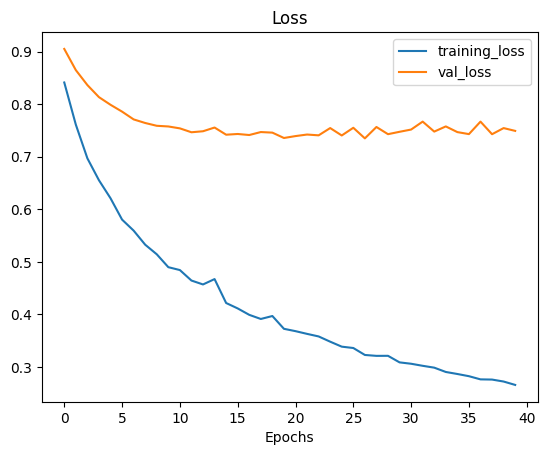

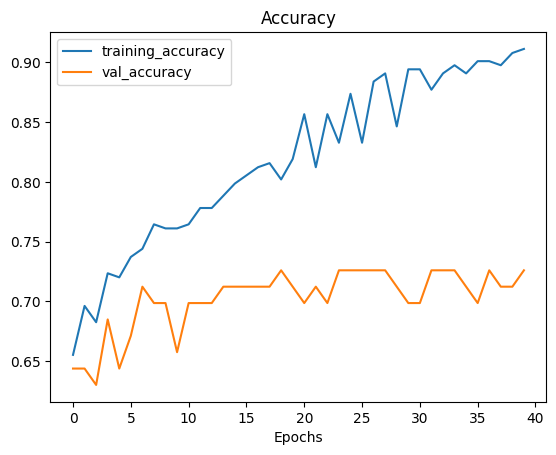

In [37]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow History object.

    Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #Plot loss

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history_0)

In [38]:
results_feature_extraction = model_0.evaluate(test_data)
results_feature_extraction

3/3 [==============================] - 1s 108ms/step - loss: 0.7491 - accuracy: 0.7260


[0.7491064667701721, 0.7260273694992065]

In [39]:

# Get the predicted probabilities for the test set
y_pred_probs = model_0.predict(test_data)

# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int)

# Get the true labels for the test set
y_true = np.concatenate([y for x, y in test_data], axis=0)

# Calculate precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred)
print("Precision:", precision)


3/3 [==============================] - 1s 137ms/step
Precision: 0.7681159420289855


In [40]:
from sklearn.metrics import recall_score

# Calculate recall
recall = recall_score(y_true, y_pred)
print("Recall:", recall)


Recall: 0.9636363636363636


In [41]:

from sklearn.metrics import f1_score
# Calculate F1-score
f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)


F1-score: 0.8548387096774193


In [42]:

# Eğitim doğruluğunu elde etmek için history_0 nesnesini kullanın
train_accuracy = history_0.history['accuracy']

# Son epoch'un eğitim doğruluğunu yazdırın
print("Eğitim doğruluğu:", train_accuracy[-1])

Eğitim doğruluğu: 0.9112628102302551
